In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [59]:
class Data(object):

    def __init__(self, path):
        self.dataset = self._build_dataset(path)

    @staticmethod
    def _build_dataset(path):
        structure = [('entrada', np.float),
                     ('salida', np.float)]

        with open(path, encoding="utf8") as data_csv:
            data_gen = ((float(line.split(',')[0]), float(line.split(',')[1]))
                        for i, line in enumerate(data_csv) if i != 0)
            data = np.fromiter(data_gen, structure)

        return data

    def split(self, percentage):  # 0.8
        X = self.dataset['entrada']
        y = self.dataset['salida']

        # X.shape[0] -> 10 (filas)

        permuted_idxs = np.random.permutation(X.shape[0])
        # 2,1,3,4,6,7,8,5,9,0

        train_idxs = permuted_idxs[0:int(percentage * X.shape[0])]
        # permuted_idxs[0:8]
        # [2,1,3,4,5,6,7,8,5]

        test_idxs = permuted_idxs[int(percentage * X.shape[0]): X.shape[0]]
        # [9,0]

        X_train = X[train_idxs]
        X_test = X[test_idxs]

        y_train = y[train_idxs]
        y_test = y[test_idxs]

        return X_train, X_test, y_train, y_test, X,y

In [159]:
dataset = Data(r'clase_8_dataset.csv')
X_train, X_test, y_train, y_test,X,y = dataset.split(0.8)

print(X_test.shape)

(100,)


Nube de puntos de todo el dataset


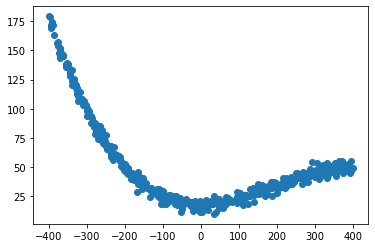

In [4]:
print("Nube de puntos de todo el dataset")
plt.scatter(X, y)

Nube de puntos del Train


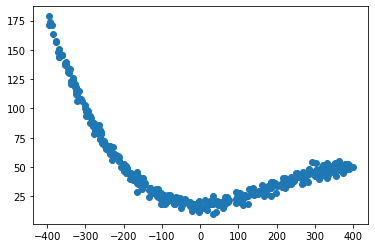

In [5]:
print("Nube de puntos del Train")
plt.scatter(X_train, y_train)

In [152]:
class Metric(object):
    def __call__(self, target, prediction):
        return NotImplemented
    
class MSE(Metric):
    def __init__(self):
        Metric.__init__(self)

    def __call__(self, target, prediction):
        n = target.size
        return np.sum((target - prediction) ** 2) / n


In [137]:
class BaseModel(object):

    def __init__(self):
        self.model = None

    def fit(self, X, Y):
        return NotImplemented

    def predict(self, X):
        return NotImplemented
    
class ConstantModel(BaseModel):

    def fit(self, X, Y):
        W = Y.mean()
        self.model = W

    def predict(self, X):
        return np.ones(len(X)) * self.model


#expandimos nuestro dataset original y le agregamos una columna de unos, lo que hacemos es que al calcular el W con la regresion afin, obtenemos la ordenada al origen
class LinearRegressionWithB(BaseModel):

    def fit(self, X, y):
        X_expanded = np.vstack((X, np.ones(len(X)))).T   #agrega una columna de unos
        W = np.linalg.inv(X_expanded.T.dot(X_expanded)).dot(X_expanded.T).dot(y)  #acá sí hace falta invertir
        self.model = W
        return W

    def predict(self, X):
        X_expanded = np.vstack((X, np.ones(len(X)))).T #la tiene que volver a expandir
        return X_expanded.dot(self.model)
    

class Quadratic_withB(BaseModel):

    def fit(self, X, y):
        X_quadratic = np.vstack((np.power(X, 2), X, np.ones(len(X)))).T   #agrega una columna de unos
        W = np.linalg.inv(X_quadratic.T.dot(X_quadratic)).dot(X_quadratic.T).dot(y)  #acá sí hace falta invertir
        self.model = W
        return W

    def predict(self, X):
        X_quadratic = np.vstack((np.power(X, 2), X, np.ones(len(X)))).T #la tiene que volver a expandir
        return X_quadratic.dot(self.model)


class Cubic_withB(BaseModel):

    def fit(self, X, y):
        X_cubic = np.vstack((np.power(X, 3),np.power(X, 2), X, np.ones(len(X)))).T   #agrega una columna de unos
        W = np.linalg.inv(X_cubic.T.dot(X_cubic)).dot(X_cubic.T).dot(y)  #acá sí hace falta invertir
        self.model = W
        return W

    def predict(self, X):
        X_cubic = np.vstack((np.power(X, 3),np.power(X, 2), X, np.ones(len(X)))).T #la tiene que volver a expandir
        return X_cubic.dot(self.model)

class Forth_withB(BaseModel):

    def fit(self, X, y):
        X_forth = np.vstack((np.power(X, 4),np.power(X, 3),np.power(X, 2), X, np.ones(len(X)))).T   #agrega una columna de unos
        W = np.linalg.inv(X_forth.T.dot(X_forth)).dot(X_forth.T).dot(y)  #acá sí hace falta invertir
        self.model = W
        return W

    def predict(self, X):
        X_forth = np.vstack((np.power(X, 4),np.power(X, 3),np.power(X, 2), X, np.ones(len(X)))).T #la tiene que volver a expandir
        return X_forth.dot(self.model)


    
    

In [119]:
l_regression_b_q = Cubic_withB()
l_regression_b_q.fit (X_train,y_train)

array([-1.01273171e-06,  6.03135137e-04,  1.15456974e-03,  1.79728086e+01])

### Ejercicio 3.a

In [114]:
def k_folds_lineal(X_train, y_train, k=5):
    l_regression_b = LinearRegressionWithB()
    error = MSE()                               #esta es la métrica que voy a usar para comparar

    chunk_size = int(len(X_train) / k)
    mse_list = []
    W = []
    min_mse = 10000
    
    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X_train) else len(X_train)
        
        #un chunk de train va a ser de validacion
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        
        #el resto de los chunks para entrenar
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])

        l_regression_b.fit(new_X_train, new_y_train)
        prediction = l_regression_b.predict(new_X_valid)
        mse_list.append(error(new_y_valid, prediction))
        
        mse_actual = error(new_y_valid, prediction)
        if mse_actual < min_mse:
            min_mse = mse_actual
            W = l_regression_b.fit(new_X_train, new_y_train)

    mean_MSE = np.mean(mse_list)

    return mean_MSE,W

In [115]:
#a continuación imprimo el error cuadrático promedio de las corridas, y los valores de los parámetros que dá
#el menor MSE dentro de los 4 entrenamientos. El criterio que uso es el MSE, que sea lo menor posible.
print(k_folds_lineal(X_train,y_train))


(856.2228265699721, array([-0.08375083, 49.24105121]))


### Ejercicio 3. b

In [108]:
def k_folds_quad(X_train, y_train, k=5):
    quadratic_withB = Quadratic_withB()
    error = MSE()                               #esta es la métrica que voy a usar para comparar

    chunk_size = int(len(X_train) / k)
    mse_list = []
    W = []
    min_mse = 10000
    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X_train) else len(X_train)
        
        #un chunk de train va a ser de validacion
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        
        #el resto de los chunks para entrenar
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])

        quadratic_withB.fit(new_X_train, new_y_train)
        prediction = quadratic_withB.predict(new_X_valid)
        mse_list.append(error(new_y_valid, prediction))
        
        mse_actual = error(new_y_valid, prediction)
        if mse_actual < min_mse:
            min_mse = mse_actual
            W = quadratic_withB.fit(new_X_train, new_y_train)

    mean_MSE = np.mean(mse_list)
    #W = quadratic_withB.fit(new_X_train, new_y_train)
    
    return mean_MSE,W

In [192]:
#A CONTINUACIÓN, EL ERROR CUADRÁTICO MEDIO PARA APROXIMACION CUADRÁTIAC Y LOS PARÁMETROS CON MENOR MCE PARA DICHO MODELO
print(k_folds_quad(X_train,y_train))
mean_MSE_quadratic, w_quadratic = k_folds_quad(X_train,y_train)


#CORRO EL MEJOR MODELO DE n=2 con EL DATASET DE TEST y CALCULO EL ERROR:

X_test_quadratic = np.vstack((np.power(X_test, 2), X_test, np.ones(len(X_test)))).T
y_predict_2 = X_test_quadratic.dot(w_quadratic)
error = MSE ()
error_test = error(y_test, y_predict_2)

print('\nEl error de test para el modelo cuadrático es: ', error_test)



(102.15710058781909, array([ 5.96260606e-04, -9.37949490e-02,  1.74381597e+01]))

El error de test para el modelo cuadrático es:  102.64316984857749


In [124]:
def k_folds_cubic(X_train, y_train, k=5):
    cubic_withB =Cubic_withB()
    error = MSE()                               #esta es la métrica que voy a usar para comparar

    chunk_size = int(len(X_train) / k)
    mse_list = []
    W = []
    min_mse = 10000
    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X_train) else len(X_train)
        
        #un chunk de train va a ser de validacion
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        
        #el resto de los chunks para entrenar
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])

        cubic_withB.fit(new_X_train, new_y_train)
        prediction = cubic_withB.predict(new_X_valid)
        mse_list.append(error(new_y_valid, prediction))
        
        mse_actual = error(new_y_valid, prediction)
        if mse_actual < min_mse:
            min_mse = mse_actual
            W = cubic_withB.fit(new_X_train, new_y_train)

    mean_MSE = np.mean(mse_list)
    
    return mean_MSE,W

In [188]:
#A CONTINUACIÓN, EL ERROR CUADRÁTICO MEDIO PARA APROXIMACION CUBICA Y LOS PARÁMETROS CON MENOR MCE PARA DICHO MODELO
print(k_folds_cubic(X_train,y_train))

mean_MSE_cubic, w_cubic = k_folds_cubic(X_train,y_train)


#CORRO EL MEJOR MODELO DE n=3 con EL DATASET DE TEST y CALCULO EL ERROR:

X_test_cubic = np.vstack((np.power(X_test, 3),np.power(X_test, 2), X_test, np.ones(len(X_test)))).T
y_predict_3 = X_test_cubic.dot(w_cubic)
error = MSE ()
error_test = error(y_test, y_predict_3)

print('\nEl error de test para el modelo cúbico es: ', error_test)



(9.61497491902718, array([-1.01106865e-06,  6.03857728e-04,  1.45275301e-03,  1.78748364e+01]))

El error de test para el modelo cúbico es:  9.817704345235883


In [138]:
def k_folds_forth(X_train, y_train, k=5):
    forth_withB =Forth_withB()
    error = MSE()                               #esta es la métrica que voy a usar para comparar

    chunk_size = int(len(X_train) / k)
    mse_list = []
    W = []
    min_mse = 10000
    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X_train) else len(X_train)
        
        #un chunk de train va a ser de validacion
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        
        #el resto de los chunks para entrenar
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])

        forth_withB.fit(new_X_train, new_y_train)
        prediction = forth_withB.predict(new_X_valid)
        mse_list.append(error(new_y_valid, prediction))
        
        mse_actual = error(new_y_valid, prediction)
        if mse_actual < min_mse:
            min_mse = mse_actual
            W = forth_withB.fit(new_X_train, new_y_train)

    mean_MSE = np.mean(mse_list)
    
    return mean_MSE,W

In [187]:
#A CONTINUACIÓN, EL ERROR CUADRÁTICO MEDIO PARA APROXIMACION CUARTA Y LOS PARÁMETROS CON MENOS MCE PARA DICHO MODELO
print(k_folds_forth(X_train,y_train))

mean_MSE_forth, w_forth = k_folds_forth(X_train,y_train)


#CORRO EL MEJOR MODELO DE n=4 con EL DATASET DE TEST y CALCULO EL ERROR:

X_test_forth = np.vstack((np.power(X_test, 4),np.power(X_test, 3),np.power(X_test, 2), X_test, np.ones(len(X_test)))).T
y_predict_4 = X_test_forth.dot(w_forth)
error = MSE ()
error_test = error(y_test, y_predict_4)

print('\nEl error de test para el modelo con n=4 es: ', error_test)




(9.610999877794523, array([-9.07908864e-11, -1.01018685e-06,  6.16176349e-04,  1.45710512e-03,
        1.76657934e+01]))

El error de test para el modelo con n=4 es:  9.902331353674224


### Ejercicio 3.c 

#### El polinomio que hace una mejor aproximación a la nube de puntos es el de grado 3, ya que es el que menor MCE promedio presenta. 

### Ejercicio 3. d


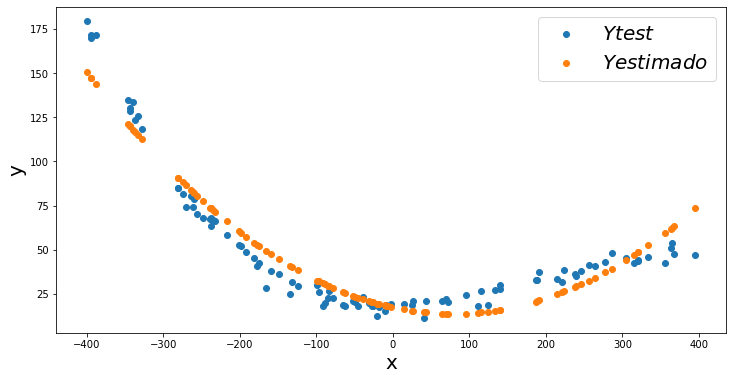

In [231]:
def plot_nube(X,y,y_predict):
        plt.figure(figsize=(12, 6))
        plt.scatter(X,y)
        plt.scatter (X,y_predict)
       
        plt.xlabel('x', size=20)
        plt.ylabel('y', size=20)
        
        plt.legend([r'$Y test$', r'$Yestimado$'], fontsize=20)
        plt.show()
        

plot_nube (X_test,y_test,y_predict)



### Ejercicio 4 

In [311]:
X_train_cubic = np.vstack((np.power(X_train, 3),np.power(X_train, 2), X_train, np.ones(len(X_train)))).T
#y_predict_3 = X_test_cubic.dot(w_cubic)

def mini_batch_gradient_descent(X_train, y_train, lr=0.01, amt_epochs=100, b=5):  #lr: learning rate
    
    """
    shapes:
        X_train = nxm
        y_train = nx1
        W = mx1
    """
    
    n = X_train.shape[0]
    m = X_train.shape[1]

    # initialize random weights
    W = w_cubic

    # iterate over the n_epochs
    for i in range(amt_epochs):
        
        # Shuffle all the samples 
        idx = np.random.permutation(X_train.shape[0])
        X_train = X_train[idx]
        y_train = y_train[idx]

        # Calculate the batch size in samples as a function of the number of batches
        batch_size = int(len(X_train) / b)
 
        # Iterate over the batches
        for i in range(0, len(X_train), batch_size):
            
            end = i + batch_size if i + batch_size <= len(X_train) else len(X_train)
            batch_X = X_train[i: end] # batch_size*m
            batch_y = y_train[i: end] # batch_size*1

            # Calculate the prediction for the whole batch
            prediction = np.matmul(batch_X, W)  # batch_sizex1
            # Calculate the error for the whole batch
            error = batch_y - prediction  # batch_sizex1
            error = np.vstack((error,np.ones(len(error))))
            
            # Calculate the gradient for the batch
            
            
            # X_expanded = np.vstack((X, np.ones(len(X)))).T  
            
            #print('llego')
            # error[batch_sizex1]*batch_X[batch_size*m]--> broadcasting --> batch_size*m
            grad_sum = np.sum(error * batch_X, axis=0) # 1xm
            grad_mul = -2/batch_size * grad_sum  # 1xm
            gradient = np.transpose(grad_mul)  # mx1
            
            # Update the weights
            W = W - (lr * gradient)

    return W

In [312]:
w_cubic_gradient = mini_batch_gradient_descent (X_train_cubic,y_train)
#X_train_cubic.shape

ValueError: operands could not be broadcast together with shapes (2,80) (80,4) 